In [56]:
import torch
from torch import optim, nn
import torchvision
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from Preprocess import Anime
from net import ResNet18
import matplotlib.pyplot as plt
import numpy as np 
from tqdm import tqdm
from tqdm import trange
from sklearn.model_selection import KFold

In [57]:
batchze = 32
lr = 1e-4
epochs = 50
device = torch.device('cuda')
torch.manual_seed(1234)
k=10
splits=KFold(n_splits=k,shuffle=True,random_state=42)

In [58]:
# load data 
all_db = Anime('..\\Images', 224, 'all')
train_db = Anime('..\\Images', 224, 'train')
val_db = Anime('..\\Images', 224, 'val')
test_db = Anime('..\\Images', 224, 'test')

In [59]:
train_loader = DataLoader(train_db,batch_size= batchze, shuffle= True, num_workers=4)
val_loader = DataLoader(val_db,batch_size= batchze, num_workers=2)
test_loader = DataLoader(test_db,batch_size= batchze, num_workers=2)



In [60]:
# helper function
def evaluate(model, loader):
    correct = 0
    total = len(loader.dataset)
    for x , y in loader:
        x, y  = x.to(device), y.to(device)
        with torch.no_grad():
            logits = model(x)
            pred = logits.argmax(dim = 1)
        correct += torch.eq(pred, y).sum().float().item()
    return correct / total

def train_epoch(model,device,dataloader,loss_fn,optimizer):
    train_loss,train_correct=0.0,0
    model.train()
    for images, labels in dataloader:

        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()

    return train_loss,train_correct

def valid_epoch(model,device,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    with torch.no_grad():
      for images, labels in dataloader:

          images,labels = images.to(device),labels.to(device)
          output = model(images)
          loss=loss_fn(output,labels)
          valid_loss+=loss.item()*images.size(0)
          scores, predictions = torch.max(output.data,1)
          val_correct+=(predictions == labels).sum().item()

    return valid_loss,val_correct
    

In [61]:

# model = ResNet18(30).to(device)
# optimizer = optim.Adam(model.parameters(),lr = lr)
# criteon = nn.CrossEntropyLoss()
# loss_data = []
# val_acc_data = []
# best_acc, best_epoch = 0, 0
# global_step = 0
# history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}
# for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(all_db)))):
#     train_sampler = SubsetRandomSampler(train_idx)
#     test_sampler = SubsetRandomSampler(val_idx)
#     train_loader = DataLoader(all_db, batch_size=batchze, sampler=train_sampler)
#     test_loader = DataLoader(all_db, batch_size=batchze, sampler=test_sampler)

#     for epoch in range(epochs):
#         train_loss, train_correct=train_epoch(model,device,train_loader,criteon,optimizer)
#         test_loss, test_correct=valid_epoch(model,device,test_loader,criteon)
#         # calculate data
#         train_loss = train_loss / len(train_loader.sampler)
#         train_acc = train_correct / len(train_loader.sampler) * 100
#         test_loss = test_loss / len(test_loader.sampler)
#         test_acc = test_correct / len(test_loader.sampler) * 100
#         print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
#                                                                                                             epochs,
#                                                                                                             train_loss,
#                                                                                                             test_loss,
#                                                                                                             train_acc,
#                                                                                                             test_acc))
#         # keep data
#         history['train_loss'].append(train_loss)
#         history['test_loss'].append(test_loss)
#         history['train_acc'].append(train_acc)
#         history['test_acc'].append(test_acc) 



# print("loaded from checkpoint! ")

# test_acc = evaluate(model, test_loader)
# print("test acc:", test_acc)


In [62]:
model = ResNet18(30).to(device)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr = lr)
criteon = nn.CrossEntropyLoss()

best_acc, best_epoch = 0, 0
global_step = 0
loss_data = []
val_acc_data = []
for epoch in trange(epochs, unit="epochs"):
    for step, (x,y) in enumerate(train_loader):
        # x: [b,3,512,512] y:[b]
        x, y  = x.to(device), y.to(device)

        logits = model(x)
        loss = criteon(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_data.append(loss.item())
        global_step += 1
    if epoch % 1 == 0:
        val_acc = evaluate(model, val_loader)
        if val_acc > best_acc:
            best_epoch = epoch
            best_acc = val_acc
            torch.save(model.state_dict(),'best_scratch.mdl')
        val_acc_data.append(val_acc)
print("best acc:", best_acc, "best epoch:", best_epoch)
model.load_state_dict(torch.load("best_scratch.mdl")) # load best state

print("loaded from checkpoint! ")

test_acc = evaluate(model, test_loader)
print("test acc:", test_acc)


100%|██████████| 50/50 [09:35<00:00, 11.50s/epochs]


best acc: 0.8344827586206897 best epoch: 28
loaded from checkpoint! 
test acc: 0.7827586206896552


In [63]:

# # avg_train_loss = np.mean(history['train_loss'])
# # avg_test_loss = np.mean(history['test_loss'])
# # avg_train_acc = np.mean(history['train_acc'])
# # avg_test_acc = np.mean(history['test_acc'])

# print('Performance of {} fold cross validation'.format(k))
# print("Average Training Loss: {:.4f} \t Average Test Loss: {:.4f} \t Average Training Acc: {:.3f} \t Average Test Acc: {:.3f}".format(avg_train_loss,avg_test_loss,avg_train_acc,avg_test_acc)) 

Text(0.5, 1.0, 'val_acc')

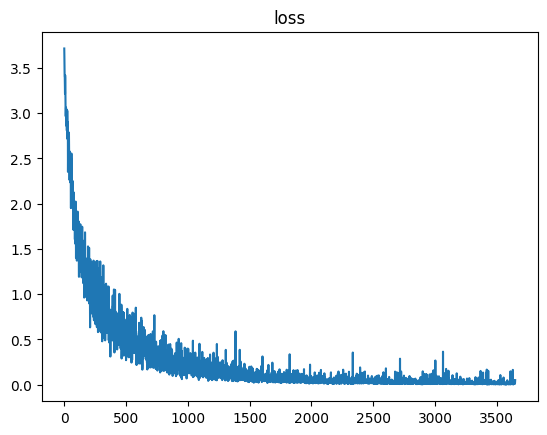

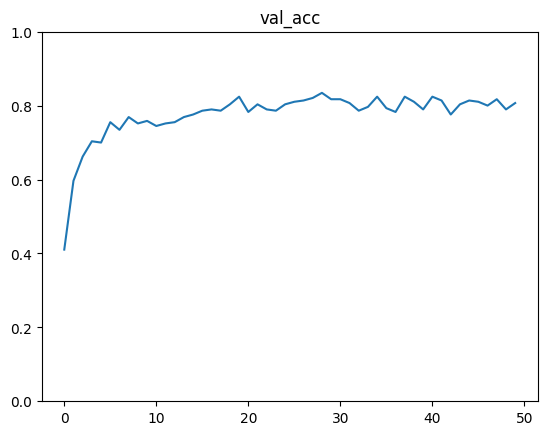

In [64]:
# display the picture of loss and val_acc
x = np.arange(0, global_step)
x_2 = np.arange(0,epoch + 1)
fig, ax = plt.subplots()
ax.plot(x, loss_data)
ax.set_title('loss')
fig2, ax2 = plt.subplots()
ax2.plot(x_2,val_acc_data)
plt.ylim([0, 1])
ax2.set_title('val_acc')

In [65]:
p = sum(map(lambda p:p.numel(), model.parameters()))
print('parameters size:', p)

parameters size: 1254110
